In [2]:
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from torchvision.transforms import ToTensor
from PIL import Image, ImageDraw
from xml.etree import ElementTree as ET
import os

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("v38nguynvit/vietnamesefoods")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vietnamesefoods


In [3]:
data_dir = os.path.join(path, "FOOD-DATASET")

train_data_dir = os.path.join(data_dir, "TRAIN")
val_data_dir = os.path.join(data_dir, "VAL")
test_data_dir = os.path.join(data_dir, "TEST")

In [4]:
class Dataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.samples = self.load_data(data_dir)
        self.transform = transform

        self.labels = sorted(set(sample['label'] for sample in self.samples))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        # get sample at indes
        sample = self.samples[index]

        # set up image's path
        filename = sample['filename']
        image_path = os.path.join(self.data_dir, filename)

        # open image
        image = Image.open(image_path)
        
        # image = np.array(image)
        transform_image = self.transform(image)

        label = self.label_to_idx[sample['label']]
        label = torch.tensor(label, dtype=torch.long)
        
        return transform_image, label

    def load_data(self, data_dir):
        data = []
        
        for label in os.listdir(data_dir):
            label_path = os.path.join(data_dir, label)
            if os.path.isdir(label_path):
                for img_file in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_file)
                    data.append({'filename': img_path, 'label': label})

        return data

In [27]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((256, 256)), # Resize ảnh về 256x256
    transforms.RandomRotation(30), # Xoay ngẫu nhiên ảnh từ -30 đến 30 độ
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), # Dịch ngẫu nhiên ảnh từ -5 đến 5 pixel theo cả hai hướng (x, y)
    transforms.ToTensor(), # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Chuẩn hóa ảnh theo mean và std mặc định của ImageNet
])

In [28]:
train_dataset = Dataset(train_data_dir, transform)
val_dataset = Dataset(val_data_dir, transform) 
test_dataset = Dataset(test_data_dir, transform)

In [29]:
len(train_dataset), len(val_dataset), len(test_dataset)

(18751, 2757, 5169)

In [30]:
img, label = train_dataset[10]
img.shape, label

(torch.Size([3, 256, 256]), tensor(5))

In [31]:
len(test_dataset.labels)

38

In [32]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [33]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [34]:
# 2. Adding Positional Embeddings
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, seq_len):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len + 1, embed_dim))  # Adjusted for [CLS] token
        # self.register_buffer('positional_embeddings', get_positional_embeddings(seq_len + 1, embed_dim), persistent=False)

    def forward(self, x):
        return x + self.pos_embed

In [35]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):
        # Chuyển từ (batch_size, seq_len, embed_dim) sang (seq_len, batch_size, embed_dim)
        x = x.transpose(0, 1)
        # Áp dụng Multi-head Attention
        x = self.attn(x, x, x)[0]
        # Chuyển lại về (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)
        return x


In [36]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [37]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=256, patch_size=32, num_classes=38, embed_dim=512, num_heads=4, depth=3, mlp_dim=1024):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, 3, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim, (img_size // patch_size) ** 2)
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim) for _ in range(depth)
        ])
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.mlp_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embedding(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.mlp_head(x[:, 0])
        return x

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [39]:
import torch.optim as optim
from tqdm import tqdm

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [40]:
import torch.nn.functional as F

weight_decay = 1e-4 

model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), 
    lr=0.005, 
    momentum=0.9, 
    weight_decay=weight_decay
)

In [41]:
len(train_loader), len(val_loader), len(test_loader)

(1172, 173, 324)

In [42]:
param_count = sum(p.numel() for p in model.parameters())
param_count

7935014

In [43]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [44]:
num_epochs = 50

In [45]:
from tqdm import tqdm
from sklearn.metrics import f1_score

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

early_stopping = EarlyStopping()


# Train Network
def training(model, num_epochs):
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []
        for data in tqdm(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            # compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            # Collect all labels and predictions for F1 score
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        accuracy = 100 * correct / total
        train_accuracy.append(accuracy)
    
        f1 = f1_score(all_labels, all_preds, average='macro')
    
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.2f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.2f}')
    
        model.eval()  # Đặt mô hình ở chế độ đánh giá
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data in tqdm(val_loader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
        
                # update running_loss
                running_loss += loss.item()
        
                # Đo lường độ chính xác
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
                # Collect all labels and predictions for F1 score
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                
            epoch_loss = running_loss / len(val_loader)
            val_losses.append(epoch_loss)
            accuracy = 100 * correct / total
            val_accuracy.append(accuracy)
    
            f1 = f1_score(all_labels, all_preds, average='macro')
            
            print(f'Test Loss: {epoch_loss:.2f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.2f}')

        early_stopping(epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

In [46]:
training(model, num_epochs)

 39%|███▉      | 455/1172 [03:20<05:04,  2.35it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [08:30<00:00,  2.30it/s]


Epoch 1/50 - Train Loss: 3.23, Accuracy: 13.53%, F1 Score: 0.10


100%|██████████| 173/173 [01:11<00:00,  2.44it/s]


Test Loss: 3.13, Accuracy: 17.19%, F1 Score: 0.10


  4%|▍         | 44/1172 [00:13<05:49,  3.22it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [06:03<00:00,  3.22it/s]


Epoch 2/50 - Train Loss: 2.91, Accuracy: 20.47%, F1 Score: 0.16


100%|██████████| 173/173 [00:49<00:00,  3.48it/s]


Test Loss: 2.86, Accuracy: 21.91%, F1 Score: 0.16


  6%|▌         | 65/1172 [00:21<06:24,  2.88it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:53<00:00,  3.31it/s]


Epoch 3/50 - Train Loss: 2.77, Accuracy: 23.89%, F1 Score: 0.20


100%|██████████| 173/173 [00:48<00:00,  3.55it/s]


Test Loss: 2.73, Accuracy: 25.39%, F1 Score: 0.20


 21%|██        | 244/1172 [01:12<04:11,  3.68it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:59<00:00,  3.26it/s]


Epoch 4/50 - Train Loss: 2.69, Accuracy: 26.04%, F1 Score: 0.22


100%|██████████| 173/173 [00:47<00:00,  3.61it/s]


Test Loss: 2.59, Accuracy: 27.60%, F1 Score: 0.22


  3%|▎         | 37/1172 [00:11<05:34,  3.39it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:54<00:00,  3.31it/s]


Epoch 5/50 - Train Loss: 2.62, Accuracy: 27.97%, F1 Score: 0.24


100%|██████████| 173/173 [00:48<00:00,  3.59it/s]


Test Loss: 2.67, Accuracy: 25.54%, F1 Score: 0.24


 43%|████▎     | 505/1172 [02:33<03:51,  2.89it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:55<00:00,  3.30it/s]


Epoch 6/50 - Train Loss: 2.56, Accuracy: 28.97%, F1 Score: 0.25


100%|██████████| 173/173 [00:49<00:00,  3.48it/s]


Test Loss: 2.63, Accuracy: 27.89%, F1 Score: 0.25


 72%|███████▏  | 839/1172 [04:14<01:41,  3.27it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:54<00:00,  3.31it/s]


Epoch 7/50 - Train Loss: 2.51, Accuracy: 30.52%, F1 Score: 0.27


100%|██████████| 173/173 [00:48<00:00,  3.59it/s]


Test Loss: 2.64, Accuracy: 26.77%, F1 Score: 0.27


  3%|▎         | 30/1172 [00:09<05:50,  3.26it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:56<00:00,  3.29it/s]


Epoch 8/50 - Train Loss: 2.48, Accuracy: 31.19%, F1 Score: 0.27


100%|██████████| 173/173 [00:47<00:00,  3.62it/s]


Test Loss: 2.59, Accuracy: 27.86%, F1 Score: 0.27


 17%|█▋        | 200/1172 [00:58<06:39,  2.43it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:54<00:00,  3.31it/s]


Epoch 9/50 - Train Loss: 2.40, Accuracy: 33.31%, F1 Score: 0.30


100%|██████████| 173/173 [00:47<00:00,  3.62it/s]


Test Loss: 2.49, Accuracy: 31.41%, F1 Score: 0.29


 49%|████▉     | 577/1172 [02:53<04:03,  2.45it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:52<00:00,  3.32it/s]


Epoch 10/50 - Train Loss: 2.38, Accuracy: 33.06%, F1 Score: 0.30


100%|██████████| 173/173 [00:47<00:00,  3.64it/s]


Test Loss: 2.53, Accuracy: 30.00%, F1 Score: 0.30


 13%|█▎        | 158/1172 [00:48<06:25,  2.63it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:52<00:00,  3.33it/s]


Epoch 11/50 - Train Loss: 2.34, Accuracy: 33.93%, F1 Score: 0.31


100%|██████████| 173/173 [00:48<00:00,  3.58it/s]


Test Loss: 2.45, Accuracy: 30.47%, F1 Score: 0.31


 47%|████▋     | 554/1172 [02:43<03:05,  3.33it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:50<00:00,  3.34it/s]


Epoch 12/50 - Train Loss: 2.30, Accuracy: 35.64%, F1 Score: 0.33


100%|██████████| 173/173 [00:47<00:00,  3.64it/s]


Test Loss: 2.36, Accuracy: 33.33%, F1 Score: 0.32


  4%|▍         | 44/1172 [00:13<05:18,  3.54it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:54<00:00,  3.30it/s]


Epoch 13/50 - Train Loss: 2.26, Accuracy: 36.21%, F1 Score: 0.33


100%|██████████| 173/173 [00:47<00:00,  3.63it/s]


Test Loss: 2.43, Accuracy: 32.50%, F1 Score: 0.33


 38%|███▊      | 442/1172 [02:11<03:01,  4.02it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:50<00:00,  3.34it/s]


Epoch 14/50 - Train Loss: 2.23, Accuracy: 37.50%, F1 Score: 0.34


100%|██████████| 173/173 [00:48<00:00,  3.57it/s]


Test Loss: 2.33, Accuracy: 34.31%, F1 Score: 0.34


 20%|██        | 239/1172 [01:14<04:40,  3.33it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:55<00:00,  3.30it/s]


Epoch 15/50 - Train Loss: 2.20, Accuracy: 38.16%, F1 Score: 0.36


100%|██████████| 173/173 [00:48<00:00,  3.56it/s]


Test Loss: 2.38, Accuracy: 34.10%, F1 Score: 0.35


  2%|▏         | 21/1172 [00:05<05:04,  3.78it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:54<00:00,  3.31it/s]


Epoch 16/50 - Train Loss: 2.16, Accuracy: 38.42%, F1 Score: 0.36


100%|██████████| 173/173 [00:47<00:00,  3.61it/s]


Test Loss: 2.49, Accuracy: 30.40%, F1 Score: 0.35


  1%|▏         | 17/1172 [00:04<06:06,  3.15it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:53<00:00,  3.32it/s]


Epoch 17/50 - Train Loss: 2.13, Accuracy: 39.28%, F1 Score: 0.37


100%|██████████| 173/173 [00:47<00:00,  3.62it/s]


Test Loss: 2.29, Accuracy: 35.62%, F1 Score: 0.37


 45%|████▌     | 533/1172 [02:39<03:10,  3.36it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:52<00:00,  3.32it/s]


Epoch 18/50 - Train Loss: 2.10, Accuracy: 40.12%, F1 Score: 0.38


100%|██████████| 173/173 [00:48<00:00,  3.59it/s]


Test Loss: 2.31, Accuracy: 37.18%, F1 Score: 0.37


 17%|█▋        | 202/1172 [01:01<04:52,  3.32it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:54<00:00,  3.30it/s]


Epoch 19/50 - Train Loss: 2.05, Accuracy: 41.51%, F1 Score: 0.39


100%|██████████| 173/173 [00:48<00:00,  3.58it/s]


Test Loss: 2.34, Accuracy: 34.35%, F1 Score: 0.38


 47%|████▋     | 547/1172 [02:42<03:11,  3.27it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:52<00:00,  3.32it/s]


Epoch 20/50 - Train Loss: 2.03, Accuracy: 42.01%, F1 Score: 0.40


100%|██████████| 173/173 [00:47<00:00,  3.62it/s]


Test Loss: 2.33, Accuracy: 36.45%, F1 Score: 0.39


 74%|███████▎  | 864/1172 [04:18<01:29,  3.42it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:54<00:00,  3.30it/s]


Epoch 21/50 - Train Loss: 2.00, Accuracy: 42.67%, F1 Score: 0.41


100%|██████████| 173/173 [00:47<00:00,  3.62it/s]


Test Loss: 2.29, Accuracy: 37.98%, F1 Score: 0.40


 38%|███▊      | 442/1172 [02:13<03:22,  3.60it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1172/1172 [05:53<00:00,  3.32it/s]


Epoch 22/50 - Train Loss: 1.97, Accuracy: 43.18%, F1 Score: 0.41


100%|██████████| 173/173 [00:48<00:00,  3.58it/s]

Test Loss: 2.37, Accuracy: 36.24%, F1 Score: 0.40
Early stopping


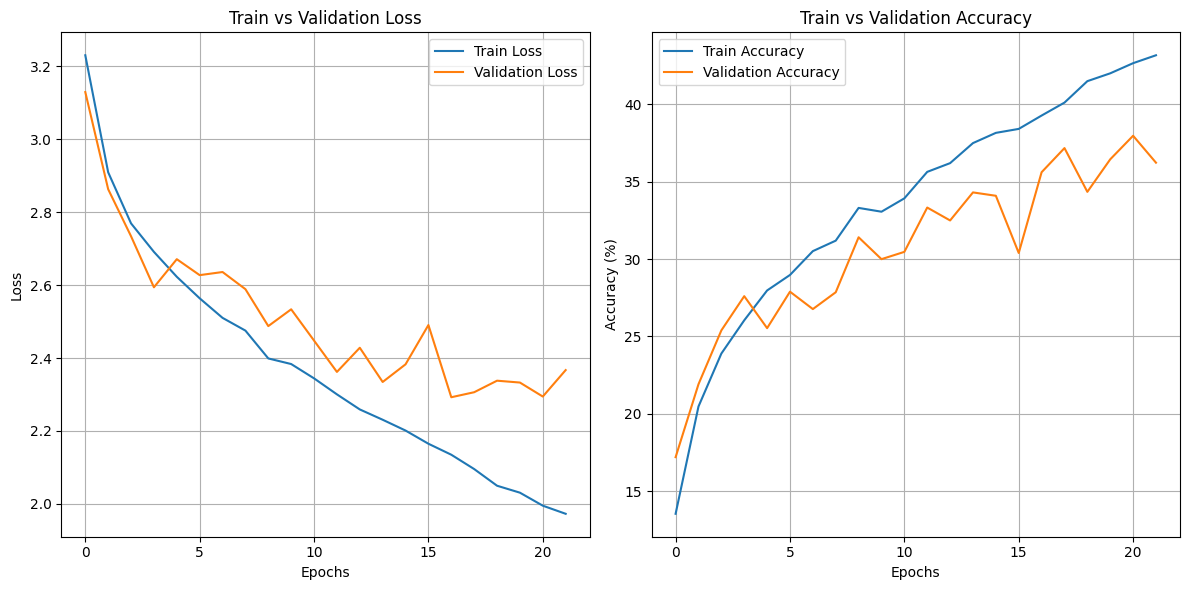

In [47]:
import matplotlib.pyplot as plt

# Vẽ đồ thị loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

# Vẽ đồ thị accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.tight_layout()
plt.show()


In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Đặt mô hình ở chế độ đánh giá
model.eval()

# Biến để lưu nhãn và dự đoán
all_labels = []
all_preds = []

# Không tính gradient khi đánh giá
with torch.no_grad():
    for inputs, labels in test_loader:
        # Chuyển dữ liệu sang thiết bị phù hợp (CPU/GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Dự đoán
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Lưu nhãn thật và dự đoán
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Sử dụng sklearn để tính toán các chỉ số
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average=None)  # None để tính cho từng nhãn
precision = precision_score(all_labels, all_preds, average=None)
f1 = f1_score(all_labels, all_preds, average=None)

In [49]:
# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.labels))


Classification Report:
                  precision    recall  f1-score   support

        Banh beo       0.65      0.43      0.52       129
    Banh bot loc       0.22      0.14      0.17       144
        Banh can       0.36      0.21      0.26       149
       Banh canh       0.27      0.06      0.09       193
      Banh chung       0.43      0.38      0.40       102
       Banh cuon       0.48      0.19      0.27       228
        Banh duc       0.15      0.14      0.15       133
        Banh gio       0.38      0.21      0.27       129
       Banh khot       0.21      0.50      0.30       167
         Banh mi       0.44      0.59      0.50       268
        Banh pia       0.59      0.49      0.54        89
        Banh tet       0.51      0.35      0.41       138
Banh trang nuong       0.47      0.44      0.45       159
        Banh xeo       0.60      0.56      0.58       235
      Bun bo Hue       0.55      0.31      0.40       306
 Bun dau mam tom       0.46      0.76      0.57

In [50]:
import torch

# Đường dẫn lưu file (thư mục Kaggle Notebook làm việc)
model_save_path = '/kaggle/working/final.pth'

# Lưu state_dict của mô hình
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/final.pth
